In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-05-02 03:25:11.491224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 03:25:11.491386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 03:25:11.688222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# current dir
!pwd

# print tree structure of the parent directory. Now we are getting somewhere, full tree of files that you care for.
!tree .. -d

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/kaggle/working
..
|-- input
|   `-- fer2013pluscleanedaugmballanced1
|       |-- test
|       |   |-- Anger
|       |   |-- Disgust
|       |   |-- Fear
|       |   |-- Happy
|       |   |-- Neutral
|       |   |-- Sad
|       |   `-- Surprise
|       `-- train
|           |-- Anger
|           |-- Disgust
|           |-- Fear
|           |-- Happy
|           |-- Neutral
|           |-- Sad
|           `-- Surprise
|-- lib
|   `-- kaggle
`-- working

21 directories


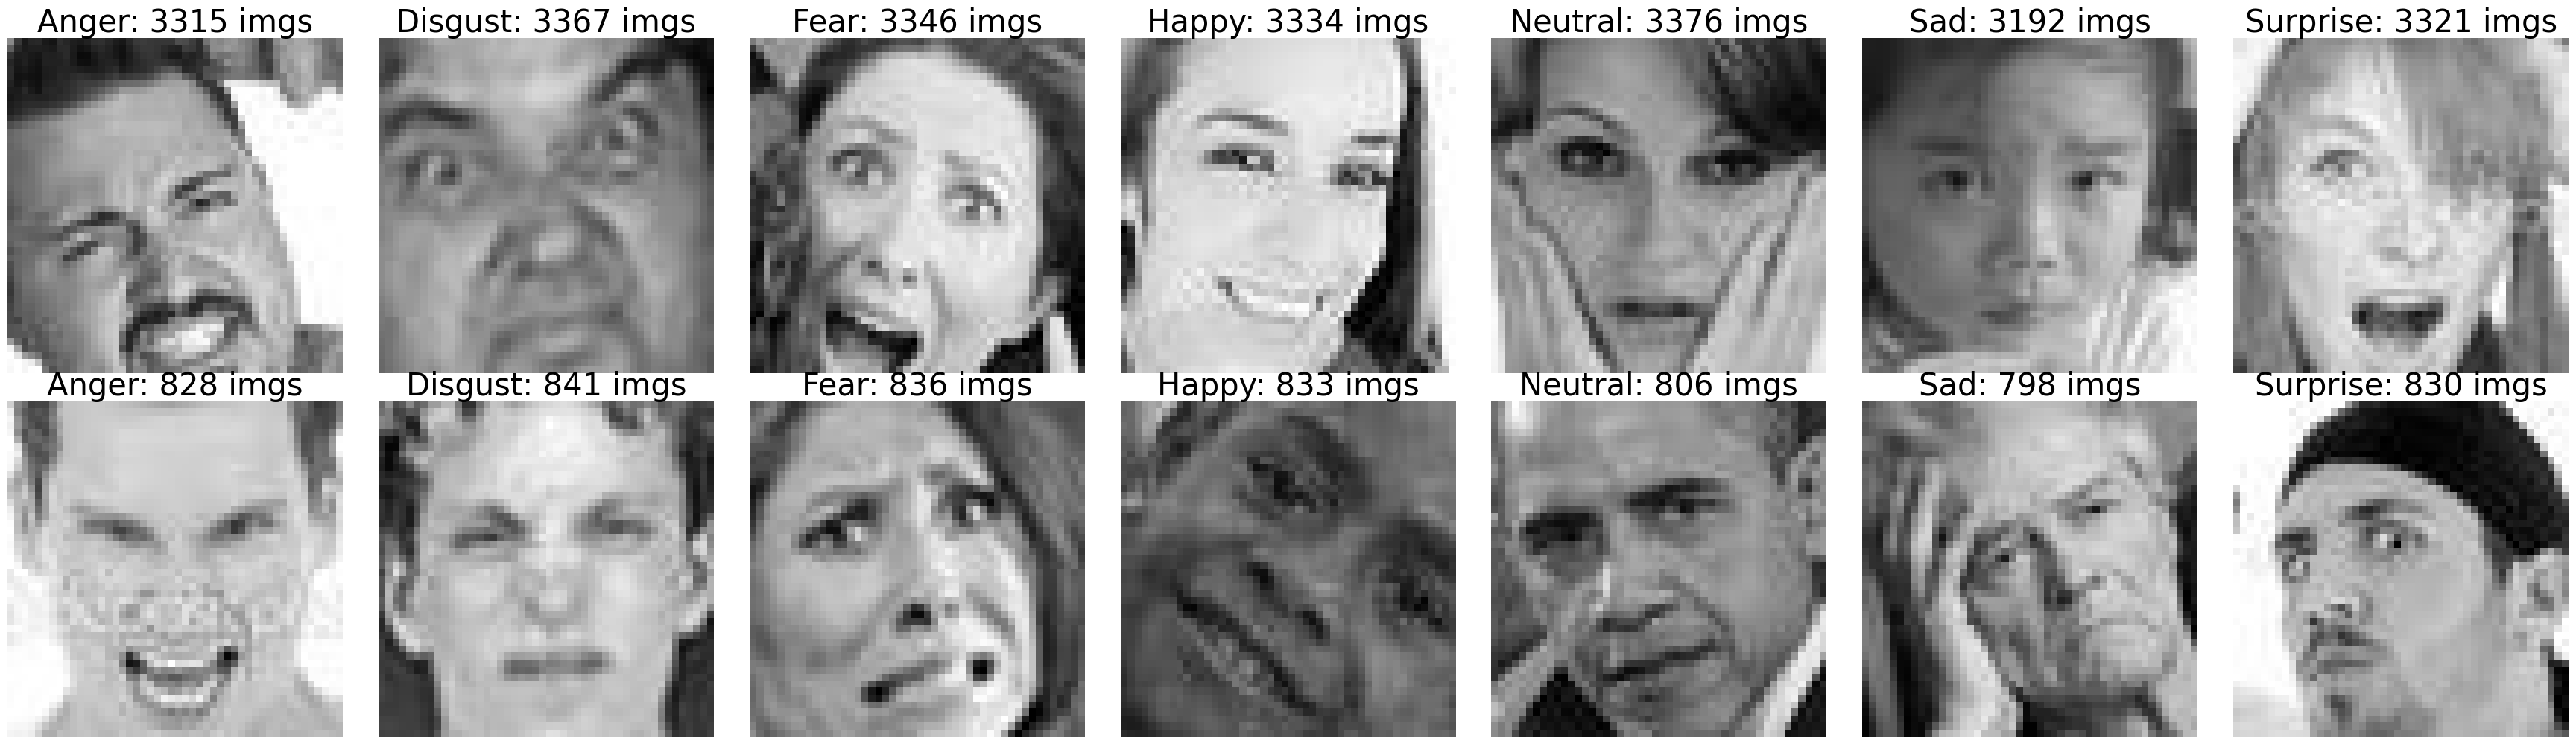

In [3]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

def preview_datasets(train_dir, test_dir, samples_per_class=3):
    train_classes = sorted(os.listdir(train_dir))
    val_classes = sorted(os.listdir(test_dir))

    total_classes = len(train_classes) # num of classes
    fig, axes = plt.subplots(nrows=2, ncols=max(1, total_classes) * samples_per_class, figsize=(5 * total_classes * samples_per_class, 10))

    # plot images
    def plot_images_for_dataset(dataset_dir, row, class_names):
        for i, cls in enumerate(class_names):
            cls_dir = os.path.join(dataset_dir, cls)
            images = os.listdir(cls_dir)
            selected_images = np.random.choice(images, min(samples_per_class, len(images)), replace=False)

            for j, image in enumerate(selected_images):
                idx = i * samples_per_class + j
                img_path = os.path.join(cls_dir, image)
                img = load_img(img_path)
                ax = axes[row, idx]
                ax.imshow(img)
                ax.set_title(f'{cls}: {len(images)} imgs', fontsize = 30)
                ax.axis('off')

    # plot training images
    plot_images_for_dataset(train_dir, 0, train_classes)
    # plot testing images
    plot_images_for_dataset(test_dir, 1, val_classes)

    plt.tight_layout()
    plt.show()

train_dir = '/kaggle/input/fer2013pluscleanedaugmballanced1/train'
test_dir = '/kaggle/input/fer2013pluscleanedaugmballanced1/test'

preview_datasets(train_dir, test_dir, samples_per_class=1)

## Generate CSV Files

KFold Cross Validation can be cumbersome if we are using flow_from_directory method, so we opt for flow_from_dataframe instead, which requires a dataframe (CSV).

In [4]:
from sklearn.utils import shuffle

def create_csv(input_dir, output_csv_path):
    data = [] #to store the file names and its labels
    
    #     list all the subdirs
    for label, subdir_name in enumerate(sorted(os.listdir(input_dir))):
        subdir_path = os.path.join(input_dir, subdir_name)
        if os.path.isdir(subdir_path): # its a legit directory
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(subdir_path, filename)
                    data.append((file_path, f'{label}'))

        df = pd.DataFrame(data, columns = ['filename', 'label'])
        df['label'] = df['label'].astype(str)
        df = shuffle(df, random_state = 42) # shuffle rows so the classes are not grouped
        df.to_csv(output_csv_path, index = False)
              
create_csv(train_dir, '/kaggle/working/train.csv')
create_csv(test_dir, '/kaggle/working/test.csv')

In [5]:
train_df = pd.read_csv('/kaggle/working/train.csv', dtype={'label': str})
print(train_df.head(5))
print(train_df.sample(5))

                                            filename label
0  /kaggle/input/fer2013pluscleanedaugmballanced1...     0
1  /kaggle/input/fer2013pluscleanedaugmballanced1...     1
2  /kaggle/input/fer2013pluscleanedaugmballanced1...     2
3  /kaggle/input/fer2013pluscleanedaugmballanced1...     3
4  /kaggle/input/fer2013pluscleanedaugmballanced1...     5
                                                filename label
21080  /kaggle/input/fer2013pluscleanedaugmballanced1...     4
7323   /kaggle/input/fer2013pluscleanedaugmballanced1...     0
6250   /kaggle/input/fer2013pluscleanedaugmballanced1...     2
10127  /kaggle/input/fer2013pluscleanedaugmballanced1...     1
15764  /kaggle/input/fer2013pluscleanedaugmballanced1...     4


## Model
For more Keras layers for transfer learning: https://keras.io/api/applications/ 

We can build the top layers using Functional or Sequential API. But imported layers from link above are Functional by default, I recommend bulding the top layers with Functional API so it does not raise error when we call load_model().

For more info about Sequential and Fucntional: https://medium.com/analytics-vidhya/keras-model-sequential-api-vs-functional-api-fc1439a6fb10

/tmp/ipykernel_33/2161895801.py:18: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetmodel = MobileNet(input_shape = (48, 48, 3), weights = 'imagenet', include_top = False)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 24, 24, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 24, 24, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 24, 24, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 24, 24, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 12, 12, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 12, 12, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 12, 12, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 12, 12, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 1, 1, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,268,487 (12.47 MB)

 Trainable params: 3,244,359 (12.38 MB)

 Non-trainable params: 24,128 (94.25 KB)

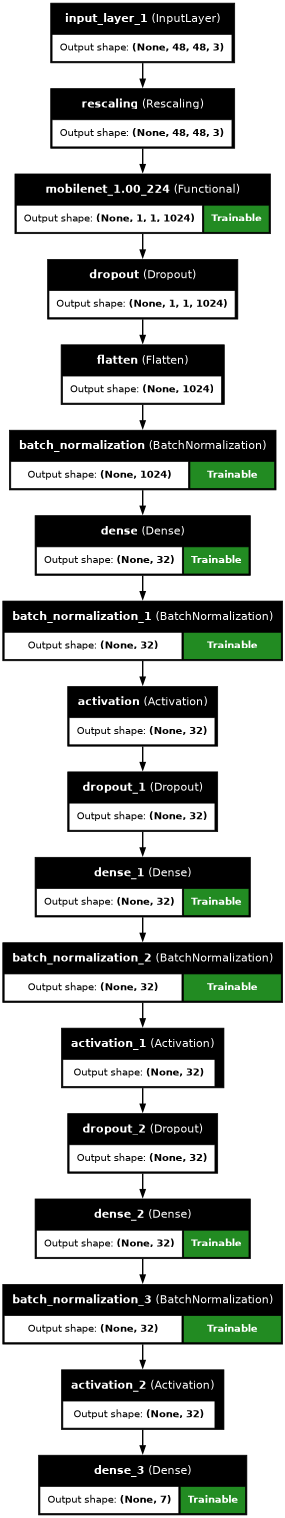

In [6]:
# model

from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.layers import Input, Rescaling, BatchNormalization, Dense, Flatten, Dropout, Activation, GaussianNoise, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.callbacks import Callback
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence

initial_learning_rate = 1e-3
epochs = 25

mobilenetmodel = MobileNet(input_shape = (48, 48, 3), weights = 'imagenet', include_top = False)
for layer in mobilenetmodel.layers[:]:
    layer.trainable = True
    
mobilenetmodel.summary()
tf.keras.utils.plot_model(mobilenetmodel, 
                          show_shapes = True, 
                          dpi = 50,
                          show_trainable = True,
                          show_layer_names = True,
                          to_file = '/kaggle/working/mobilenet.png'
                         )

def get_model():
    
    # try using Functional instead of Sequential
    img_input = Input(shape = (48, 48, 3))
    x = Rescaling(1./255)(img_input)
    x = mobilenetmodel(x)

    # build our own top layers
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(32, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(32, kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    outputs = Dense(7, activation='softmax')(x)
    
    model = Model(inputs = img_input, outputs = outputs)

#     # Sequential method
#     model = Sequential()
#     model.add(mobilenetmodel)
#     # build our own top model
#     model.add(Dropout(0.5))
#     model.add(Flatten())
#     model.add(BatchNormalization())
#     model.add(Dense(32,kernel_initializer='he_uniform'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))

#     model.add(Dense(32,kernel_initializer='he_uniform'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))

#     model.add(Dense(32,kernel_initializer='he_uniform'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dense(7, activation='softmax')) 

    # compile
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = initial_learning_rate, decay = 1e-3/epochs),
                loss = 'categorical_crossentropy',
                metrics = ['acc', Precision(), Recall()])

    return model

model = get_model()
model.summary()

tf.keras.utils.plot_model(model, 
                          show_shapes = True, 
                          dpi = 50,
                          show_trainable = True,
                          show_layer_names = True,
                          to_file = '/kaggle/working/whole_model.png'
                         )


In [11]:
# callbacks

from sklearn.metrics import f1_score, precision_score, recall_score
from keras.callbacks import Callback

# 1. ReduceLROnPlateau
lrd = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.5, patience = 7, min_lr = 1e-7, verbose = 1)

# 2. ModelCheckpoint
model_checkpoint = ModelCheckpoint('/kaggle/working/best_model.weights.h5', 
                                   save_best_only=True,
                                   save_weights_only=True,
                                   monitor = 'val_acc', 
                                   verbose = 1)

# 3. Early Stopping
early_stopping = EarlyStopping(monitor = 'val_acc', min_delta = 0.00005, patience = 11, verbose = 1, restore_best_weights = True)

In [ ]:
from sklearn.model_selection import KFold

datagen = ImageDataGenerator(
    rescale = 1./255,
    # validation_split = 0.2, not needed. validation will be created using k splits
    rotation_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
    )

kfold = KFold(n_splits = 5, shuffle = True, random_state = 40)
fold_no = 1

all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

for train_index, val_index in kfold.split(train_df):
    train_data = train_df.iloc[train_index]
    val_data = train_df.iloc[val_index]

    train_generator = datagen.flow_from_dataframe(
        train_data,
        directory = None, # directory — (str)Path to the directory which contains all the images. set this to None if your x_col contains absolute_paths pointing to each image files instead of just filenames.
        x_col = "filename",
        y_col = "label",
        class_mode = 'categorical',
        shuffle = True,
        target_size = (48, 48),
        batch_size=32
        )
    val_generator = datagen.flow_from_dataframe(
        val_data,
        directory = None, # directory — (str)Path to the directory which contains all the images. set this to None if your x_col contains absolute_paths pointing to each image files instead of just filenames.
        x_col = "filename",
        y_col = "label",
        class_mode = 'categorical',
        shuffle = False,
        target_size = (48, 48),
        batch_size=32
        )

    model = get_model()

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history=model.fit(train_generator,
                    epochs = epochs,
                    validation_data=val_generator,
                    callbacks=[lrd, 
                               model_checkpoint,
                               early_stopping
                               ],
                    verbose = 1)

    all_train_acc.append(history.history['acc'])
    all_val_acc.append(history.history['val_acc'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    fold_no += 1

In [ ]:
# Find the maximum length of any fold's metrics
max_length = max(max([len(acc) for acc in all_train_acc]), max([len(acc) for acc in all_val_acc]))

# Function to pad metrics lists to max_length
def pad_metrics(metrics_list, max_length):
    return [np.pad(metrics, (0, max_length - len(metrics)), 'edge') for metrics in metrics_list]

# Pad all metrics
padded_train_acc = pad_metrics(all_train_acc, max_length)
padded_val_acc = pad_metrics(all_val_acc, max_length)
padded_train_loss = pad_metrics(all_train_loss, max_length)
padded_val_loss = pad_metrics(all_val_loss, max_length)

# Now calculate the averages
avg_train_acc = np.mean(padded_train_acc, axis=0)
avg_val_acc = np.mean(padded_val_acc, axis=0)
avg_train_loss = np.mean(padded_train_loss, axis=0)
avg_val_loss = np.mean(padded_val_loss, axis=0)

epochs_range = range(1, len(avg_train_acc) + 1)

plt.figure(figsize=(14, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, avg_train_acc, label='Average Training Accuracy')
plt.plot(epochs_range, avg_val_acc, label='Average Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, avg_train_loss, label='Average Training Loss')
plt.plot(epochs_range, avg_val_loss, label='Average Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Evaluation

This is the part where we evaluate the model **using the test set** based on these evaluation metrics: 
1. Accuracy
2. Precision
3. Recall
4. F1 Score
5. Confusion matrix

In [ ]:
best_model = tf.keras.models.load_model('/kaggle/working/best_model.keras')
test_df = pd.read_csv('/kaggle/working/test.csv', dtype={'label': str})

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory = None,
    x_col = 'filename',
    y_col = 'label',
    class_mode = 'categorical',
    target_size = (48, 48),
    batch_size = 32,
    shuffle = False # for testing, keep this to False
)

# make predictions
predictions = best_model.predict(test_generator)
y_pred = np.argmax(predictions, axis = 1) # convert one hot encoding preds to labels
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # or 'micro', 'weighted'
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
! ls